In [1]:
# Implementations and trick on Best of Both World, Transferring Knowledge from 
# Discriminative Learning to a Generative Visual Dialog Model


In [4]:
# #########################################################
# Background: What's visual dialog and evaluation metric. #
# #########################################################

# download the data.
import skimage.io as io
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

path = 'data'
if not os.path.exists(os.path.join(path, 'visdial_0.9_val.json')):
    os.system('wget https://s3.amazonaws.com/visual-dialog/v0.9/visdial_0.9_train.zip -P %s' %(path))
    os.system('wget https://s3.amazonaws.com/visual-dialog/v0.9/visdial_0.9_val.zip -P %s' %(path))
    # unzip 
    os.system('unzip %s/visdial_0.9_train.zip -d %s' %(path, path))
    os.system('unzip %s/visdial_0.9_val.zip -d %s' %(path, path))


In [3]:
# show visual dialog example here. 
print('Loading visual dialog v0.9 json data...')
visdial_file = json.load(open(os.path.join(path, 'visdial_0.9_val.json'), 'r'))

dialogs = visdial_file['data']['dialogs']
rand_idx = np.random.randint(0,len(dialogs))
image_id = dialogs[rand_idx]['image_id']
print(rand_idx)

I = io.imread('http://images.cocodataset.org/val2014/COCO_val2014_%012d.jpg' %(image_id))
plt.axis('off')
plt.imshow(I)
plt.show()

print('Caption: %s.' %dialogs[rand_idx]['caption'])
print('\n')
for qas in dialogs[rand_idx]['dialog']:
    question = visdial_file['data']['questions'][qas['question']]
    gt_answer = visdial_file['data']['answers'][qas['answer']]
    print('Q: %s --A: %s' %(question, gt_answer))

Loading visual dialog v0.9 json data...


IOError: [Errno 2] No such file or directory: 'data/visdial_0.9_val.json'

## Evaluation Protocol


Retrieval setting -- Every question in VisDial is coupled with a list of 100 candidate 
answer options, which the models are asked to sort for evaluation purpos. 

* Mean Rank
* Recall @k
* Mean Reciprocal Rank (MRR)

In [4]:
# Define the data Loader
from __future__ import print_function
import torch
import misc.dataLoader as dl

# download pre-processed data.
if not os.path.exists(os.path.join(path, 'visdial_data.h5')):
    os.system('wget https://filebox.ece.vt.edu/~jiasenlu/codeRelease/visDial.pytorch/data/vdl_img_vgg.h5 -P %s' %(path))
    os.system('wget https://filebox.ece.vt.edu/~jiasenlu/codeRelease/visDial.pytorch/data/visdial_data.h5 -P %s' %(path))
    os.system('wget https://filebox.ece.vt.edu/~jiasenlu/codeRelease/visDial.pytorch/data/visdial_params.json -P %s' %(path))
    
# download pre-trained model.
if not os.path.exists(os.path.join(path, 'HCIAE-D-MLE')):
    os.system('wget https://filebox.ece.vt.edu/~jiasenlu/codeRelease/visDial.pytorch/model/HCIAE-D-MLE.pth -P %s' %(path))
    os.system('wget https://filebox.ece.vt.edu/~jiasenlu/codeRelease/visDial.pytorch/model/HCIAE-G-MLE.pth -P %s' %(path))
    os.system('wget https://filebox.ece.vt.edu/~jiasenlu/codeRelease/visDial.pytorch/model/HCIAE-G-DIS.pth -P %s' %(path))

opt = {}
opt['data_dir'] = 'data'
opt['input_img_h5'] = 'vdl_img_vgg.h5'
opt['input_ques_h5'] = 'visdial_data.h5'
opt['input_json'] = 'visdial_params.json'
opt['negative_sample'] = 99
opt['num_val'] = 100


input_img_h5 = os.path.join(opt['data_dir'], opt['input_img_h5'])
input_ques_h5 = os.path.join(opt['data_dir'], opt['input_ques_h5'])
input_json = os.path.join(opt['data_dir'], opt['input_json'])

# create dataloader
dataset_val = dl.validate(input_img_h5=input_img_h5, input_ques_h5=input_ques_h5,
                input_json=input_json, negative_sample = opt['negative_sample'],
                num_val = opt['num_val'], data_split = 'val')

dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1,
                                         shuffle=False, num_workers=0)

# fetch a sample data.
data_iter_val = iter(dataloader_val)
data = data_iter_val.next()

sample_image, sample_history, sample_question, sample_answer, sample_answerT, sample_questionL, sample_opt_answer, \
        sample_opt_answerT, sample_answer_ids, sample_answerLen, sample_opt_answerLen, sample_img_id = data

ans_length = sample_answer.size(2)
his_length = sample_history.size(2)

print('image feature shape:', sample_image.size())
print('history shape:', sample_history.size())
print('question shape:', sample_question.size())
print('answer shape:', sample_answer.size())
print('option answer shape:', sample_opt_answer.size())

DataLoader loading: val
Loading image feature from data/vdl_img_vgg.h5
val number of data: 100
Loading txt from data/visdial_data.h5
Vocab Size: 8964
image feature shape: torch.Size([1, 7, 7, 512])
history shape: torch.Size([1, 10, 24])
question shape: torch.Size([1, 10, 16])
answer shape: torch.Size([1, 10, 9])
option answer shape: torch.Size([1, 10, 100, 9])


## Encoder -- History-Conditioned Image Attentive Encoder
<img src="imgs/Fig1.png", width="600">

In [7]:
# Encoder
from misc.model import _netW
from misc.encoder_QIH import _netE
from torch.autograd import Variable
from misc.utils import repackage_hidden
import torch.nn as nn

opt['ninp'] = 300
opt['nhid'] = 512
opt['nlayers'] = 1
opt['img_feat_size'] = 512
opt['dropout'] = 0.5
opt['model'] = 'LSTM'
opt['n_word'] = dataset_val.vocab_size
opt['load_model'] = True

class Encoder(nn.Module):
    def __init__(self, opt, checkpoint=None):
        super(Encoder, self).__init__()
        # build the encoder model.
        self.netW = _netW(opt['n_word'], opt['ninp'], opt['dropout'])
        self.netE = _netE(opt['model'], opt['ninp'], opt['nhid'], opt['nlayers'], opt['dropout'], opt['img_feat_size'])
        if checkpoint:
            self.netW.load_state_dict(checkpoint['netW'])
            self.netE.load_state_dict(checkpoint['netE'])
        
    def forward(self, question, history, image, ques_hidden, hist_hidden, rnd):
        ques = question[:,rnd,:].t()
        his = history[:,:rnd+1,:].clone().view(-1, his_length).t()

        image = image.view(-1, 512)
        ques_emb = self.netW(Variable(ques.long()), format = 'index')
        his_emb = self.netW(Variable(his.long()), format = 'index')
    
        ques_hidden = repackage_hidden(ques_hidden, 1)
        hist_hidden = repackage_hidden(hist_hidden, rnd+1)
        feat, ques_hidden = self.netE(ques_emb, his_emb, Variable(image), ques_hidden, hist_hidden, rnd+1)
        return feat, ques_hidden


# load the pre-trained model.
checkpoint_D = torch.load('save_model/HCIAE-D-MLE.pth')

rnd = 1
encoder = Encoder(opt, checkpoint_D)
encoder.eval()
ques_hidden = encoder.netE.init_hidden(1)
hist_hidden = encoder.netE.init_hidden(1)
encoder_D_feat, ques_hidden = encoder(sample_question, sample_history, sample_image, ques_hidden, hist_hidden, rnd)

print("output size --> :", encoder_D_feat.size())

output size --> : torch.Size([1, 300])


## Discriminative Decoder


In [8]:
# Decoder: Discriminator
from misc.model import _netD

class Discriminator(nn.Module):
    def __init__(self, opt, checkpoint=None):
        super(Discriminator, self).__init__()
        # build the discriminator model.
        self.opt = opt
        self.netW = _netW(opt['n_word'], opt['ninp'], opt['dropout'])        
        self.netD = _netD(opt['model'], opt['ninp'], opt['nhid'], opt['nlayers'], opt['n_word'], opt['dropout'])
        if checkpoint:
            self.netW.load_state_dict(checkpoint['netW'])
            self.netD.load_state_dict(checkpoint['netD'])
        
    def forward(self, opt_answer, opt_hidden, rnd):
        opt_ans = opt_answer[:,rnd,:].clone().view(-1, ans_length).t()
        opt_ans_emb = self.netW(Variable(opt_ans.long()), format = 'index')
        opt_hidden = repackage_hidden(opt_hidden, opt_ans.size(1))
        opt_feat = self.netD(opt_ans_emb, Variable(opt_ans.long()), opt_hidden, self.opt['n_word'])
        
        return opt_feat

# forward the example here. 
discriminator = Discriminator(opt, checkpoint_D)
discriminator.eval()
opt_hidden = discriminator.netD.init_hidden(1)
opt_ans_feat = discriminator(sample_opt_answerT, opt_hidden, rnd)

print("input size:", sample_opt_answerT.size())
print("output_size:", opt_ans_feat.size())

input size: torch.Size([1, 10, 100, 9])
output_size: torch.Size([100, 300])


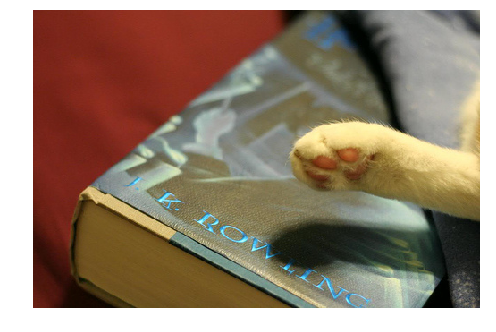

Q: [u'are ', u'there ', u'any ', u'other ', u'animals ', u'in ', u'the ', u'room ', u'? ', '', '', '', '', '', '', '']


Top 5 answer: 
A: [u'no ', '', '', '', '', '', '', '', '']
A: [u'no ', u'other ', u'animals ', '', '', '', '', '', '']
A: [u'0 ', '', '', '', '', '', '', '', '']
A: [u'np ', '', '', '', '', '', '', '', '']
A: [u'part ', u'of ', u'1 ', '', '', '', '', '', '']
A: [u'nope ', '', '', '', '', '', '', '', '']
A: [u'no ', u', ', u'i ', u'see ', u'no ', u'1 ', '', '', '']
A: [u'no ', u', ', u'not ', u'that ', u'i ', u'can ', u'see ', '', '']
A: [u'i ', u'don ', '', '', '', '', '', '', '']
A: [u'yes ', '', '', '', '', '', '', '', '']


Last 5 answer: 
A: [u'yes ', u'the ', u'spectators ', u'and ', u'catcher ', u'and ', u'umpire ', '', '']
A: [u'very ', u'low ', u'for ', u'a ', u'passenger ', u'jet ', '', '', '']
A: [u'blue ', u', ', u'and ', u'blue ', u', ', u'white ', u', ', u'and ', '']
A: [u'green ', '', '', '', '', '', '', '', '']
A: [u'daytime ', '', '', '', '', '', '', 

In [9]:
from misc.utils import decode_txt

# Visualize an random sample from the testset. 
encoder_D_feat = encoder_D_feat.view(-1, opt['ninp'], 1)
opt_ans_feat = opt_ans_feat.view(1, -1, opt['ninp'])
score = torch.bmm(opt_ans_feat, encoder_D_feat)
sort_score, sort_idx = torch.sort(score, 1, descending=True)

# print the image. 
I = io.imread('http://images.cocodataset.org/train2014/COCO_train2014_%012d.jpg' %(sample_img_id[0]))
plt.axis('off')
plt.imshow(I)
plt.show()

# decode the question:
print('Q:', decode_txt(dataset_val.itow, sample_questionL[:,rnd,:]))

# decode the ranked option answer:
print("\n")
print("Top 5 answer: ")
for i in range(10):
    print("A:", decode_txt(dataset_val.itow, sample_opt_answerT[:,rnd, sort_idx.data[0][i][0],:]))

print("\n")
print("Last 5 answer: ")
for i in range(5):
    print("A:", decode_txt(dataset_val.itow, sample_opt_answerT[:,rnd, sort_idx.data[0][-(i+1)][0],:]))

### Metric learning multi-class N-pair loss:

$$ \mathcal{L}_{D} =  \mathcal{L}_{n-pair}\Big(\{ e_t, a^{gt}_t, \{a^-_{t, i}\}_{i=1}^{N-1} \}, f\Big) = 
\overbrace{
\log \Bigg(1 + \sum_{i=1}^{N} \exp \Big(  \underbrace{e^\top_t f(a^-_{t,i}) - e^\top_t f(a^{gt}_t)}_{\text{score margin}} \Big)
\Bigg)}^{\text{logistic loss}} $$


In [10]:
class nPairLoss(nn.Module):
    """
    Given the right, fake, wrong, wrong_sampled embedding, use the N Pair Loss
    objective (which is an extension to the triplet loss)

    Loss = log(1+exp(feat*wrong - feat*right + feat*fake - feat*right)) + L2 norm.

    Improved Deep Metric Learning with Multi-class N-pair Loss Objective (NIPS)
    """
    def __init__(self, ninp, margin):
        super(nPairLoss, self).__init__()
        self.ninp = ninp
        self.margin = np.log(margin)

    def forward(self, feat, right, wrong):
        num_wrong = wrong.size(1)
        batch_size = feat.size(0)  
        feat = feat.view(-1, self.ninp, 1)
        # e_t * a^gt
        right_dis = torch.bmm(right.view(-1, 1, self.ninp), feat)        
        # e_t * a^-
        wrong_dis = torch.bmm(wrong, feat)
        wrong_score = torch.sum(torch.exp(wrong_dis - right_dis.expand_as(wrong_dis)),1)
        loss_dis = torch.sum(torch.log(wrong_score + 1))
        loss_norm = right.norm() + feat.norm() + wrong.norm()
        return loss_dis + loss_norm
    


## Generative Setting

<img src="imgs/Fig3.png", width="500">


In [12]:
# Decoder: Generator
from misc.netG import _netG

checkpoint_G = torch.load('save_model/HCIAE-G-MLE.pth')
netG = _netG(opt['model'], opt['n_word'], opt['ninp'], opt['nhid'], opt['nlayers'], opt['dropout'])
netG.load_state_dict(checkpoint_G['netG'])

netW = _netW(opt['n_word'], opt['ninp'], opt['dropout'])
netW.load_state_dict(checkpoint_G['netW'])

# reload the encoder:
encoder_G = Encoder(opt, checkpoint_G)
encoder_G.eval()
netW.eval()
netG.eval()


_netG (
  (rnn): LSTM(300, 512, dropout=0.5)
  (decoder): Linear (512 -> 8965)
)

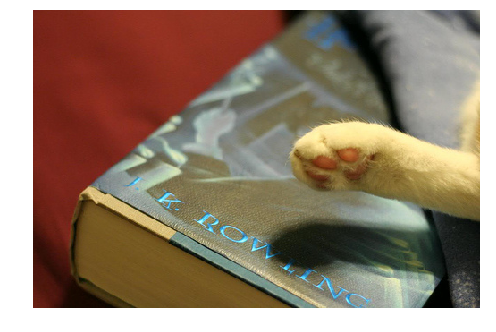

Q: [u'are ', u'there ', u'any ', u'other ', u'animals ', u'in ', u'the ', u'room ', u'? ', '', '', '', '', '', '', '']


Sampled answer:  [u'no ']


GT answer:  [u"ca n't tell "]


In [13]:
# run the generation example here. 

ques_hidden = encoder_G.netE.init_hidden(1)
hist_hidden = encoder_G.netE.init_hidden(1)
encoder_G_feat, ques_hidden = encoder_G(sample_question, sample_history, sample_image, ques_hidden, hist_hidden, rnd)

hidden_replicated = []
for hid in ques_hidden:
    hidden_replicated.append(hid.view(opt['nlayers'], 1, 1, \
        opt['nhid']).expand(opt['nlayers'], 1, 100, opt['nhid']).clone().view(opt['nlayers'], -1, opt['nhid']))
hidden_replicated = tuple(hidden_replicated)

# sample the answer here. 
# ========================
# feed e_t at the first time step.
_, ques_hidden = netG(encoder_G_feat.view(1,-1,opt['ninp']), ques_hidden)

ans_sample_result = torch.Tensor(ans_length, 1)
ans_sample = torch.LongTensor(1)
ans_sample.resize_((1, 1)).fill_(opt['n_word'])
for t in range(ans_length):
    ans_sample_embed = netW(Variable(ans_sample))
    output, ques_hidden = netG(ans_sample_embed, ques_hidden)
    _, idx = torch.max(output, 1)
    ans_sample.copy_(idx.data)
    ans_sample_result[t].copy_(ans_sample.view(-1))    

# print the image. 
I = io.imread('http://images.cocodataset.org/train2014/COCO_train2014_%012d.jpg' %(sample_img_id[0]))
plt.axis('off')
plt.imshow(I)
plt.show()

# decode the question:
print('Q:', decode_txt(dataset_val.itow, sample_questionL[:,rnd,:]))

# decode the ranked option answer:
print("\n")
print("Sampled answer: ", decode_txt(dataset_val.itow, ans_sample_result))

print("\n")
print("GT answer: ", decode_txt(dataset_val.itow, sample_answerT[:,rnd,:].t()))

In [14]:
# rank the answer. 
# =================
ans_input = Variable(sample_opt_answer[:,rnd,:,:].clone().view(-1, ans_length).t().long())
ans_target = Variable(sample_opt_answerT[:,rnd,:].clone().view(-1, ans_length).t().long())
ans_emb = netW(ans_input, format = 'index')
output, _ = netG(ans_emb, hidden_replicated)
logprob = - output
logprob_select = torch.gather(logprob, 1, ans_target.view(-1,1))

mask = ans_target.data.eq(0)  # generate the mask
if isinstance(logprob, Variable):
    mask = Variable(mask, volatile=logprob.volatile)
logprob_select.masked_fill_(mask.view_as(logprob_select), 0)

prob = logprob_select.view(ans_length, -1, 100).sum(0).view(-1,100)
sort_score, sort_idx = torch.sort(prob, 1)

print("\n")
print("Top 5 answer: ")
for i in range(10):
    print("A:", decode_txt(dataset_val.itow, sample_opt_answerT[:,rnd, sort_idx.data[0][i],:]))

print("\n")
print("Last 5 answer: ")
for i in range(5):
    print("A:", decode_txt(dataset_val.itow, sample_opt_answerT[:,rnd, sort_idx.data[0][-(i+1)],:]))



Top 5 answer: 
A: [u'nope ', '', '', '', '', '', '', '', '']
A: [u'no ', '', '', '', '', '', '', '', '']
A: [u'0 ', '', '', '', '', '', '', '', '']
A: [u'no ', u'other ', u'animals ', '', '', '', '', '', '']
A: [u'yes ', '', '', '', '', '', '', '', '']
A: [u'1 ', '', '', '', '', '', '', '', '']
A: [u'not ', u'that ', u'i ', u'can ', u'see ', '', '', '', '']
A: [u'2 ', '', '', '', '', '', '', '', '']
A: [u'maybe ', '', '', '', '', '', '', '', '']
A: [u'3 ', '', '', '', '', '', '', '', '']


Last 5 answer: 
A: [u'sitting ', u'with ', u'computer ', u'to ', u'its ', u'back ', u'staring ', u'into ', '']
A: [u'grey ', u'primarily ', u'towards ', u'top ', u'with ', u'white ', u'patch ', u'on ', '']
A: [u'*yes ', u'there ', u'is ', u'1 ', u'towel ', u'i ', u'missed ', u'it ', '']
A: [u'there ', u'are ', u'some ', u'cups ', u', ', u'1 ', u'person ', u'brought ', '']
A: [u'i ', u'see ', u'the ', u'person ', u"'s ", u'hand ', u'holding ', u'the ', '']


## Discriminative Setting vs. Generative Setting
<img src="imgs/Fig4.png", width="300">

How to transfer the knowledge from D to G ? 

<img src="imgs/Fig7.png", width="600">

$$ \mathcal{L}_{G} =  \mathcal{L}_{1-pair}\Big(\{ e_t, a^{*}_t, a^{gt}_t \}, f\Big) = 
\log \Bigg(1 + \exp \Big(e^\top_t f(a^{gt}_t) - e^\top_t f(a^{*}_t) \Big)
\Bigg) $$

G repeatly queries D with generated answer and update itself. G's goal is to have a* score higher than the correct answer, under D's learned embedding and scoring function.

In [ ]:
# #########################################################
# Algorithm: How to transfer the knowledge from D to G.   #
# #########################################################
# Implementation Here

gt_ans_feat = discriminator(sample_answerT[0,rnd].view(1,1,-1), opt_hidden, 0)
sample_ans_feat = discriminator(ans_sample_result.view(1,1,-1), opt_hidden, 0)

crit_g = nPairLoss(opt['ninp'], 2)

# def forward(self, feat, right, wrong):
loss_g = crit_g(encoder_D_feat.view(1,-1), sample_ans_feat, gt_ans_feat.view(1,1,-1))


## Enable backpropgation -- Gumble softmax trick
<img src="imgs/Fig8_1.png", width="700"> (Figure from Jang, Eric, Shixiang Gu, and Ben Poole. "Categorical reparameterization with gumbel-softmax." arXiv preprint arXiv:1611.01144 (2016).)


<img src="imgs/Fig6.png", width="500">



In [ ]:
####################################
# Straight through Gumbel Softmax  #
####################################
import torch.nn.functional as F

class gumbel_sampler(nn.Module):
    def __init__(self):
        super(gumbel_sampler, self).__init__()

    def forward(self, input, noise, temperature=0.5):

        eps = 1e-20
        noise.data.add_(eps).log_().neg_()
        noise.data.add_(eps).log_().neg_()
        y = (input + noise) / temperature
        y = F.softmax(y)

        max_val, max_idx = torch.max(y, y.dim()-1)
        y_hard = y == max_val.view(-1,1).expand_as(y)
        y = (y_hard.float() - y).detach() + y

        return y, max_idx.view(1, -1)#, log_prob


sampler = gumbel_sampler()

ques_hidden = encoder_G.netE.init_hidden(1)
hist_hidden = encoder_G.netE.init_hidden(1)
encoder_G_feat, ques_hidden = encoder_G(sample_question, sample_history, sample_image, ques_hidden, hist_hidden, rnd)

_, ques_hidden = netG(encoder_G_feat.view(1,-1,opt['ninp']), ques_hidden)

ans_sample_result = torch.Tensor(ans_length, 1)
ans_sample = torch.LongTensor(1)
ans_sample.resize_((1, 1)).fill_(opt['n_word'])

sampled_one_hot = []
# get the noise
noise_input = Variable(torch.Tensor(ans_length, 1, opt['n_word']+1))
noise_input.data.uniform_(0,1)

for t in range(ans_length):
    ans_sample_embed = netW(Variable(ans_sample))
    output, ques_hidden = netG(ans_sample_embed, ques_hidden)
    one_hot, idx = sampler(output, noise_input[t], 0.5)
    ans_sample.copy_(idx.data)
    ans_sample_result[t].copy_(ans_sample.view(-1))
    sampled_one_hot.append(one_hot.view(1, -1, opt['n_word']+1))


sampled_one_hot = torch.cat(sampled_one_hot, 0)

# decode the ranked option answer:
print("\n")
print("Gumbel Sampler's answer: ", decode_txt(dataset_val.itow, ans_sample_result))


<img src="imgs/Fig9.png", width="600">

* Embedding layer take the word index as input to get the word embdding. It can not output gradient, but much more memory efficient. 
* We need gradient from the discriminator (one-hot vector as input), thus Linear layer to get the word embedding. 
* Instead of modify the low level cuda code, we can define a linear layer which share the parameter with the word embedding layer. 

In [ ]:
####################################################
# Trick 1: Share Word Embedding with Linear Layer  #
####################################################
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.nn import Module

class share_Linear(Module):
    def __init__(self, weight):
        super(share_Linear, self).__init__()
        self.in_features = weight.size(0)
        self.out_features = weight.size(1)
        self.weight = weight.t()
        self.register_parameter('bias', None)

    def forward(self, input):
        return F.linear(input, self.weight, self.bias)

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.in_features) + ' -> ' \
            + str(self.out_features) + ')'

share_linear = share_Linear(encoder.netW.word_embed.weight)
sampled_embedding = share_linear(sampled_one_hot.view(-1, opt['n_word']+1))
print("Size of one-hot enocding:", sampled_one_hot.view(-1, opt['n_word']+1).size())
print("Size of answer enocding:", sampled_embedding.size())

#### Show the Loss plot only using the discriminative loss

#### Show reason and assumption about this. 



In [ ]:
###########################################################
# Trick 2: Adjust ratio of Discriminant Perceptual Loss   #
###########################################################






